In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, AveragePooling2D

In [3]:
# Define Inception 1 Block
def conv_block1(input, num_filters):
    x1 = Conv2D(num_filters, 1, padding = "same")(input)
    x2 = Conv2D(num_filters, 3, padding = "same")(input)
    x3 = Conv2D(num_filters, 5, padding = "same")(input)
    x4 = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding="same")(input)
    x = concatenate([x1, x2, x3, x4])
    x = Conv2D(num_filters, 3, padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    
    return x

In [4]:
# Define Inception 2 Block
def conv_block2(input, num_filters):
    x1 = Conv2D(num_filters, 1, padding = "same")(input)
    x2 = Conv2D(num_filters, 3, padding = "same")(input)
    x4 = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding="same")(input)
    x = concatenate([x1, x2, x4])
    x = Conv2D(num_filters, 3, padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    
    return x

In [5]:
# Define Convolutional Block
def conv_block(input, num_filters):

    x = Conv2D(num_filters, 3, padding = "same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

In [6]:
# Define Encoder
def encoder_block1(input, num_filters):
    x = conv_block1(input, num_filters)
    p = MaxPooling2D((2,2))(x)
    return x, p

def encoder_block2(input, num_filters):
    x = conv_block2(input, num_filters)
    p = MaxPooling2D((2,2))(x)
    return x, p

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling2D((2,2))(x)
    return x, p

In [7]:
# Define Decoder
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2,2), strides = 2, padding = "same")(input)
    x = concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [8]:
# Define Network
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block1(inputs, 32)
    s2, p2 = encoder_block2(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)
    
    outputs = Conv2D(1,1, padding = "same", activation = "sigmoid")(d4)
    
    model = Model(inputs, outputs, name = "U-Net")
    return model

In [9]:
import tensorflow as tf
import os
from pathlib import Path
import numpy as np
from tqdm import tqdm
from skimage import color
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import random

In [10]:
# Test for GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Num GPUs Available:  1


In [11]:
# Define Training Set & Testing Set
IMG_WIDTH = 448
IMG_HEIGHT = 448
IMG_CHANNELS = 3
Train_X_dir = Path(r'C:\Users\tenso\Downloads\New Project\Set\Crack\images')
Train_Y_dir = Path(r'C:\Users\tenso\Downloads\New Project\Set\Crack\masks')
Test_X_dir = Path(r'C:\Users\tenso\Downloads\New Project\Set\Crack\sample')
Train_X_ids = next(os.walk(Train_X_dir))[2]
Train_Y_ids = next(os.walk(Train_Y_dir))[2]
Test_X_ids = next(os.walk(Test_X_dir))[2]
Train_X_path = 'Set/Crack/images/'
Train_Y_path = 'Set/Crack//masks/'
Test_X_path = 'Set/Crack/sample/'
Train_X = np.zeros((len(Train_X_ids), IMG_HEIGHT, IMG_WIDTH,3), dtype=np.uint8)
Train_Y = np.zeros((len(Train_Y_ids), IMG_HEIGHT, IMG_WIDTH,1), dtype=bool)
Test_X = np.zeros((len(Test_X_ids), IMG_HEIGHT, IMG_WIDTH,3), dtype=np.uint8)
for n, id_ in tqdm(enumerate(Train_X_ids), total=len(Train_X_ids)):
    print(id_)
    img_paths = Train_X_path + id_
    img = imread(img_paths)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Train_X[n] = img
    msk_paths = Train_Y_path + id_
    msk = imread(msk_paths)[:,:]
    msk = resize(msk, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    msk = np.expand_dims(msk,axis=-1)
    Train_Y[n]=msk
    

sizes_test = []
for n, id_ in tqdm(enumerate(Test_X_ids), total=len(Test_X_ids)):
    print(id_)
    img_paths = Test_X_path + id_
    img = imread(img_paths)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    # img = color.rgb2gray(img)
    Test_X[n] = img

  2%|█▌                                                                                | 2/107 [00:00<00:05, 19.05it/s]

CRACK500_20160222_080850_1281_361.jpg
CRACK500_20160222_080850_1281_721.jpg
CRACK500_20160222_080850_1921_1.jpg
CRACK500_20160222_080850_1921_361.jpg
CRACK500_20160222_080850_1_361.jpg


  7%|██████▏                                                                           | 8/107 [00:00<00:04, 20.67it/s]

CRACK500_20160222_080850_641_361.jpg
CRACK500_20160222_080850_641_721.jpg
CRACK500_20160222_080933_361_1.jpg
CRACK500_20160222_080933_361_1921.jpg
CRACK500_20160222_080933_361_641.jpg


 10%|████████▎                                                                        | 11/107 [00:00<00:04, 21.24it/s]

CRACK500_20160222_080933_721_1.jpg
CRACK500_20160222_080933_721_1921.jpg
CRACK500_20160222_080933_721_641.jpg


 13%|██████████▌                                                                      | 14/107 [00:00<00:04, 21.65it/s]

CRACK500_20160222_081011_1281_721.jpg
CRACK500_20160222_081011_1921_721.jpg


 16%|████████████▊                                                                    | 17/107 [00:00<00:04, 21.58it/s]

CRACK500_20160222_081011_1_361.jpg
CRACK500_20160222_081011_1_721.jpg
CRACK500_20160222_081011_641_361.jpg
CRACK500_20160222_081011_641_721.jpg
CRACK500_20160222_081031_1281_361.jpg


 19%|███████████████▏                                                                 | 20/107 [00:00<00:04, 21.15it/s]

CRACK500_20160222_081031_1921_361.jpg
CRACK500_20160222_081031_1_721.jpg


 21%|█████████████████▍                                                               | 23/107 [00:01<00:03, 21.45it/s]

CRACK500_20160222_081031_641_361.jpg
CRACK500_20160222_081031_641_721.jpg
CRACK500_20160222_081102_1281_361.jpg


 24%|███████████████████▋                                                             | 26/107 [00:01<00:03, 21.36it/s]

CRACK500_20160222_081102_1281_721.jpg


 27%|█████████████████████▉                                                           | 29/107 [00:01<00:03, 21.32it/s]

CRACK500_20160222_081102_1921_1.jpg
CRACK500_20160222_081102_1921_1081.jpg
CRACK500_20160222_081102_1921_361.jpg
CRACK500_20160222_081102_1921_721.jpg
CRACK500_20160222_081102_1_721.jpg


 30%|████████████████████████▏                                                        | 32/107 [00:01<00:03, 21.20it/s]

CRACK500_20160222_081102_641_361.jpg
CRACK500_20160222_081102_641_721.jpg
CRACK500_20160222_081111_1281_361.jpg


 33%|██████████████████████████▍                                                      | 35/107 [00:01<00:03, 21.02it/s]

CRACK500_20160222_081111_1281_721.jpg


 36%|████████████████████████████▊                                                    | 38/107 [00:01<00:03, 20.94it/s]

CRACK500_20160222_081111_1921_721.jpg
CRACK500_20160222_081111_1_1.jpg
CRACK500_20160222_081111_1_361.jpg
CRACK500_20160222_081111_641_361.jpg
CRACK500_20160222_081113_1281_361.jpg


 38%|███████████████████████████████                                                  | 41/107 [00:01<00:03, 20.95it/s]

CRACK500_20160222_081113_1281_721.jpg
CRACK500_20160222_081113_1921_721.jpg
CRACK500_20160222_081113_1_361.jpg


 41%|█████████████████████████████████▎                                               | 44/107 [00:02<00:03, 21.00it/s]

CRACK500_20160222_081113_1_721.jpg


 44%|███████████████████████████████████▌                                             | 47/107 [00:02<00:02, 21.14it/s]

CRACK500_20160222_081113_641_361.jpg
CRACK500_20160222_081113_641_721.jpg
CRACK500_20160222_081839_1281_1.jpg
CRACK500_20160222_081839_1281_1081.jpg
CRACK500_20160222_081839_1281_361.jpg


 47%|█████████████████████████████████████▊                                           | 50/107 [00:02<00:02, 21.10it/s]

CRACK500_20160222_081839_1281_721.jpg
CRACK500_20160222_081839_1921_361.jpg
CRACK500_20160222_081839_641_721.jpg


 50%|████████████████████████████████████████                                         | 53/107 [00:02<00:02, 21.09it/s]

CRACK500_20160222_081908_1281_1.jpg


 52%|██████████████████████████████████████████▍                                      | 56/107 [00:02<00:02, 21.17it/s]

CRACK500_20160222_081908_1281_1081.jpg
CRACK500_20160222_081908_1281_721.jpg
CRACK500_20160222_081908_1_1.jpg
CRACK500_20160222_081908_1_1081.jpg
CRACK500_20160222_081908_1_361.jpg


 55%|████████████████████████████████████████████▋                                    | 59/107 [00:02<00:02, 20.27it/s]

CRACK500_20160222_081908_1_721.jpg
CRACK500_20160222_081908_641_361.jpg
CRACK500_20160222_081908_641_721.jpg


 58%|██████████████████████████████████████████████▉                                  | 62/107 [00:02<00:02, 20.22it/s]

CRACK500_20160222_082414_1281_1081.jpg
CRACK500_20160222_082414_1281_361.jpg
CRACK500_20160222_082414_1_361.jpg
CRACK500_20160222_082414_641_361.jpg


 61%|█████████████████████████████████████████████████▏                               | 65/107 [00:03<00:02, 19.97it/s]

CRACK500_20160222_114759_1281_1.jpg
CRACK500_20160222_114759_1281_721.jpg


 64%|███████████████████████████████████████████████████▍                             | 68/107 [00:03<00:01, 20.04it/s]

CRACK500_20160222_114759_1921_1.jpg
CRACK500_20160222_114759_1921_1081.jpg
CRACK500_20160222_114759_1921_361.jpg


 66%|█████████████████████████████████████████████████████▋                           | 71/107 [00:03<00:01, 20.04it/s]

CRACK500_20160222_114759_1921_721.jpg
CRACK500_20160222_114759_1_1081.jpg
CRACK500_20160222_114759_1_361.jpg
CRACK500_20160222_114759_1_721.jpg


 69%|████████████████████████████████████████████████████████                         | 74/107 [00:03<00:01, 20.13it/s]

CRACK500_20160222_114759_641_1.jpg
CRACK500_20160222_114759_641_1081.jpg


 72%|██████████████████████████████████████████████████████████▎                      | 77/107 [00:03<00:01, 19.94it/s]

CRACK500_20160222_114759_641_361.jpg
CRACK500_20160222_114806_1281_1.jpg
CRACK500_20160222_114806_1281_1081.jpg


 74%|███████████████████████████████████████████████████████████▊                     | 79/107 [00:03<00:01, 19.83it/s]

CRACK500_20160222_114806_1281_361.jpg


 78%|██████████████████████████████████████████████████████████████▊                  | 83/107 [00:04<00:01, 19.76it/s]

CRACK500_20160222_114806_1281_721.jpg
CRACK500_20160222_115219_1281_361.jpg
CRACK500_20160222_115219_1281_721.jpg
CRACK500_20160222_115219_1921_1081.jpg
CRACK500_20160222_115219_641_361.jpg


 79%|████████████████████████████████████████████████████████████████▎                | 85/107 [00:04<00:01, 19.53it/s]

CRACK500_20160222_115224_1281_1.jpg
CRACK500_20160222_115224_1281_721.jpg
CRACK500_20160222_115224_1921_1081.jpg


 82%|██████████████████████████████████████████████████████████████████▌              | 88/107 [00:04<00:00, 19.91it/s]

CRACK500_20160222_115224_641_1.jpg
CRACK500_20160222_115224_641_1081.jpg


 85%|████████████████████████████████████████████████████████████████████▉            | 91/107 [00:04<00:00, 20.24it/s]

CRACK500_20160222_115224_641_361.jpg
CRACK500_20160222_115233_1281_361.jpg
CRACK500_20160222_115233_1281_721.jpg
CRACK500_20160222_115233_1_721.jpg


 88%|███████████████████████████████████████████████████████████████████████▏         | 94/107 [00:04<00:00, 20.39it/s]

CRACK500_20160222_115233_641_361.jpg
CRACK500_20160222_115305_1281_1081.jpg
CRACK500_20160222_115305_1921_1081.jpg


 91%|█████████████████████████████████████████████████████████████████████████▍       | 97/107 [00:04<00:00, 20.55it/s]

CRACK500_20160222_115305_1921_361.jpg
CRACK500_20160222_115305_641_1.jpg


 93%|██████████████████████████████████████████████████████████████████████████▊     | 100/107 [00:04<00:00, 20.67it/s]

CRACK500_20160222_115305_641_1081.jpg
CRACK500_20160222_115305_641_361.jpg
CRACK500_20160222_115305_641_721.jpg


 96%|█████████████████████████████████████████████████████████████████████████████   | 103/107 [00:04<00:00, 20.54it/s]

CRACK500_20160222_115324_1281_1.jpg


 99%|███████████████████████████████████████████████████████████████████████████████▎| 106/107 [00:05<00:00, 20.66it/s]

CRACK500_20160222_115324_1281_361.jpg
CRACK500_20160222_115324_1_1.jpg
CRACK500_20160222_115324_641_1081.jpg


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [00:05<00:00, 20.56it/s]

CRACK500_20160222_115324_641_721.jpg



 23%|███████████████████▏                                                               | 3/13 [00:00<00:00, 24.98it/s]

CFD_001.jpg
CFD_005.jpg
CFD_018.jpg
CFD_069.jpg
CFD_111.jpg
CFD_112.jpg


 46%|██████████████████████████████████████▎                                            | 6/13 [00:00<00:00, 25.17it/s]

CRACK500_20160222_080850_1_361.jpg
CRACK500_20160222_080850_641_721.jpg
CRACK500_20160222_115219_641_1.jpg


 69%|█████████████████████████████████████████████████████████▍                         | 9/13 [00:00<00:00, 24.94it/s]

CRACK500_20160222_115224_1281_361.jpg
CRACK500_20160222_163940_641_1.jpg
CRACK500_20160222_163940_641_1081.jpg


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 24.78it/s]

RGB2.jpg


In [12]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [13]:
# Model Hyperparameters
model = build_unet(input_shape)
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics = ['Accuracy'])

In [14]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 448, 448, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 448, 448, 32  128         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

                                                                                                  
 batch_normalization_4 (BatchNo  (None, 56, 56, 256)  1024       ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_4 (Activation)      (None, 56, 56, 256)  0           ['batch_normalization_4[0][0]']  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 56, 56, 256)  590080      ['activation_4[0][0]']           
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 56, 56, 256)  1024       ['conv2d_10[0][0]']              
 rmalization)                                                                                     
          

 ormalization)                  )                                                                 
                                                                                                  
 activation_12 (Activation)     (None, 224, 224, 64  0           ['batch_normalization_12[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 224, 224, 64  36928       ['activation_12[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_13 (BatchN  (None, 224, 224, 64  256        ['conv2d_18[0][0]']              
 ormalization)                  )                                                                 
          

In [46]:
# Train
checkpointer = tf.keras.callbacks.ModelCheckpoint('crack_seg.h5', verbose=1, save_best_only=True)
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4),
            tf.keras.callbacks.TensorBoard(log_dir='logs')]
result = model.fit(Train_X,Train_Y, validation_split=0.1, batch_size=4, epochs=100, callbacks=callbacks)

Epoch 1/100
24/24 [==============================] - 5s 214ms/step - loss: 0.0400 - Accuracy: 0.9827 - val_loss: 0.0630 - val_Accuracy: 0.9792
Epoch 2/100
24/24 [==============================] - 5s 214ms/step - loss: 0.0391 - Accuracy: 0.9831 - val_loss: 0.0470 - val_Accuracy: 0.9811
Epoch 3/100
24/24 [==============================] - 5s 214ms/step - loss: 0.0388 - Accuracy: 0.9832 - val_loss: 0.0507 - val_Accuracy: 0.9796
Epoch 4/100
24/24 [==============================] - 5s 214ms/step - loss: 0.0451 - Accuracy: 0.9815 - val_loss: 0.2089 - val_Accuracy: 0.9078
Epoch 5/100
24/24 [==============================] - 5s 215ms/step - loss: 0.0399 - Accuracy: 0.9829 - val_loss: 0.0561 - val_Accuracy: 0.9807
Epoch 6/100
24/24 [==============================] - 5s 215ms/step - loss: 0.0385 - Accuracy: 0.9834 - val_loss: 0.0436 - val_Accuracy: 0.9816
Epoch 7/100
24/24 [==============================] - 5s 215ms/step - loss: 0.0393 - Accuracy: 0.9827 - val_loss: 0.0454 - val_Accuracy: 0.9815

In [19]:
# Predict
preds_test = model.predict(Test_X, verbose=1)

1/1 [==============================] - 4s 4s/step


In [15]:
# Step Function (not necessary)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [20]:
a=0

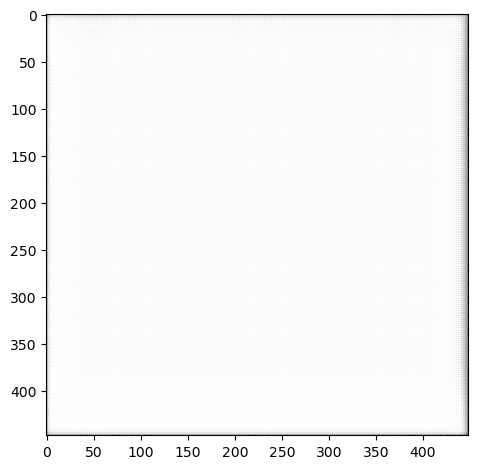

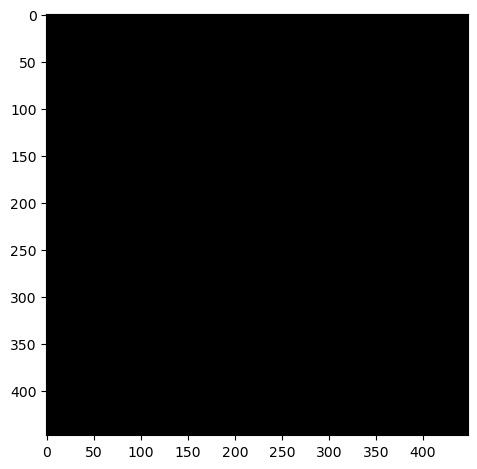

In [24]:
# Show Result
imshow(preds_test[a])
plt.show()
imshow(Test_X[a])
a=a+1

In [ ]:
model.save("my_model")

In [17]:
# Test for Other Sets
Test_P_dir = Path(r'C:\Users\tenso\Downloads\New Project\Set\Crack\sample')
Test_P_ids = next(os.walk(Test_P_dir))[2]
Test_P_path = 'Set/Crack/sample/'
Test_P = np.zeros((len(Test_P_ids), IMG_HEIGHT, IMG_WIDTH,3), dtype=np.uint8)

sizes_test = []
for n, id_ in tqdm(enumerate(Test_P_ids), total=len(Test_P_ids)):
    print(id_)
    img_paths = Test_P_path + id_
    img = imread(img_paths)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    # img = color.rgb2gray(img)
    Test_P[n] = img

 23%|███████████████████▏                                                               | 3/13 [00:00<00:00, 25.91it/s]

CFD_001.jpg
CFD_005.jpg
CFD_018.jpg
CFD_069.jpg
CFD_111.jpg
CFD_112.jpg


 69%|█████████████████████████████████████████████████████████▍                         | 9/13 [00:00<00:00, 25.19it/s]

CRACK500_20160222_080850_1_361.jpg
CRACK500_20160222_080850_641_721.jpg
CRACK500_20160222_115219_641_1.jpg
CRACK500_20160222_115224_1281_361.jpg
CRACK500_20160222_163940_641_1.jpg
CRACK500_20160222_163940_641_1081.jpg


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 24.78it/s]

RGB2.jpg


In [69]:
# Test for Other Sets
Test_P_dir = Path(r'C:\Users\tenso\Downloads\New Project\Set\CFD\CFD1')
Test_P_ids = next(os.walk(Test_P_dir))[2]
Test_P_path = 'Set/CFD/CFD1/'
Test_P = np.zeros((len(Test_P_ids), IMG_HEIGHT, IMG_WIDTH,3), dtype=np.uint8)

sizes_test = []
for n, id_ in tqdm(enumerate(Test_P_ids), total=len(Test_P_ids)):
    print(id_)
    img_paths = Test_P_path + id_
    img = imread(img_paths)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    # img = color.rgb2gray(img)
    Test_P[n] = img

 17%|█████████████▊                                                                     | 3/18 [00:00<00:00, 25.67it/s]

CFD_002.jpg
CFD_003.jpg
CFD_004.jpg
CFD_006.jpg
CFD_007.jpg
CFD_008.jpg


 50%|█████████████████████████████████████████▌                                         | 9/18 [00:00<00:00, 26.44it/s]

CFD_009.jpg
CFD_010.jpg
CFD_011.jpg
CFD_012.jpg
CFD_013.jpg
CFD_014.jpg


 83%|████████████████████████████████████████████████████████████████████▎             | 15/18 [00:00<00:00, 25.58it/s]

CFD_015.jpg
CFD_016.jpg
CFD_017.jpg
CFD_019.jpg
CFD_020.jpg
CFD_021.jpg


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 25.67it/s]


In [70]:
preds_test_P = model.predict(Test_P, verbose=1)

1/1 [==============================] - 4s 4s/step


In [71]:
a=0

In [90]:
imshow(preds_test_P[a])
plt.show()
imshow(Test_P[a])
a=a+1

IndexError: index 18 is out of bounds for axis 0 with size 18

In [47]:
Train_X=0

In [48]:
Train_Y=0